# Clasificación con Multiperceptrón de Tensorflow
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

### Carga de Datos

In [2]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd

import time
from matplotlib import pyplot as plt

df_train = pd.read_csv(DATOS_DIR + 'optdigits_train.csv')
df_test = pd.read_csv(DATOS_DIR + 'optdigits_test.csv')

df_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,"""class"""
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


## Visualizando algunos dígitos de df_train

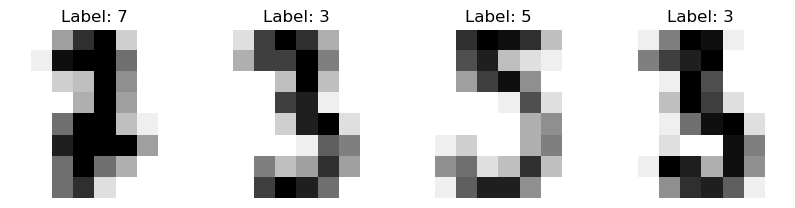

In [3]:
# Selecciona 4 filas aleatorias del dataframe
sample_images = df_train.sample(4)

# Extrae las imágenes y las etiquetas (asumiendo que las etiquetas están en la última columna)
images = sample_images.iloc[:, :-1].values
labels = sample_images.iloc[:, -1].values

# Redimensiona las imágenes a 8x8
images = images.reshape((4, 8, 8))

# Crea una figura con 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap=plt.cm.gray_r) #cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

## Preparando los datos para la red

**Convertimos los data frames en arreglos de numpy**

In [4]:
# -- la última columna tiene el número al que corresponde el dígito --
X_train = np.array(df_train.iloc[:,:-1]).astype(float)
Y_train = np.array(df_train.iloc[:,-1])

X_test = np.array(df_test.iloc[:,:-1]).astype(float)
Y_test = np.array(df_test.iloc[:,-1])

print("X_train.shape = ", X_train.shape, "    Y_train.shape = ", Y_train.shape)
print("X_test.shape  = ", X_test.shape, "    Y_test.shape  = ", Y_test.shape)


X_train.shape =  (3823, 64)     Y_train.shape =  (3823,)
X_test.shape  =  (1797, 64)     Y_test.shape  =  (1797,)


**La cantidad de neuronas de las capas de entrada y salida las determina el problema**

In [5]:
entradas = X_train.shape[1]

#-- la red tendrá una salida para cada dígito
salidas = len(np.unique(Y_train))
print("entradas = %d ; salidas = %d" % (entradas, salidas))

entradas = 64 ; salidas = 10


El valor esperado para cada ejemplo debe ser indicado utilizando una notación binaria con el objetivo de indicarle a cada neurona de la capa de salida cuál es el valor que se espera que devuelva. De esta forma, cada neurona de salida calculará su propio error y ajustará sus parámetros según la función de costo indicada.

In [6]:
Y_trainB = to_categorical(Y_train)
Y_testB  = to_categorical(Y_test)

auxs = [43,60,78]   # elegimos algunas filas sólo para ver qué contienen
print(Y_train[auxs])
print(Y_trainB[auxs,:])

[9 7 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Normalizamos los datos de entrada**

In [7]:
# normalizador = preprocessing.MinMaxScaler()  #nomalización lineal entre 0 y 1
normalizador  = preprocessing.StandardScaler()
X_train = normalizador.fit_transform(X_train)
X_test  = normalizador.transform(X_test)
    

### Definición del modelo

In [8]:
ocultas = 15


# Crear un modelo de capas secuenciales
model=Sequential()

# Agregar las capas al modelo
model.add(Input(shape=[entradas]))
model.add(Dense(ocultas, activation='tanh'))
model.add(Dense(salidas, activation='sigmoid'))

# Imprimir un resumen del modelo
model.summary()

model.compile(optimizer=SGD(learning_rate=0.1), loss='mse', metrics='accuracy')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                975       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento de la red

In [9]:
print("Inicio ...")
tIni = time.time()

parada = 1

if parada == 0:
    #-- observe el tiempo de entrenamiento y la precisión de los resultados para
    # distintos valores de batch_size = None, 32, 200 ---
    H = model.fit(X_train,Y_trainB, epochs=400, batch_size=None, validation_split=0.2, verbose=0)
else:
    es = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=1e-03, restore_best_weights=True)

    H = model.fit(x = X_train, y = Y_trainB, epochs=400,
                  validation_data = (X_test, Y_testB),  callbacks=[es])   #validation_split=0.2

tFin = time.time()
print("duración %.7f seg" % (tFin- tIni))

Inicio ...
Epoch 1/400
120/120 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.2066 - val_loss: 0.1946 - val_accuracy: 0.3194
Epoch 2/400
120/120 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.4240 - val_loss: 0.1493 - val_accuracy: 0.4702
Epoch 3/400
120/120 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.5585 - val_loss: 0.1189 - val_accuracy: 0.5559
Epoch 4/400
120/120 [==============================] - 0s 2ms/step - loss: 0.1075 - accuracy: 0.6356 - val_loss: 0.0985 - val_accuracy: 0.6188
Epoch 5/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.6845 - val_loss: 0.0850 - val_accuracy: 0.6633
Epoch 6/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.7227 - val_loss: 0.0759 - val_accuracy: 0.7017
Epoch 7/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.7510 - val_loss: 0.0695 - val_accur

Epoch 58/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9566 - val_loss: 0.0197 - val_accuracy: 0.9354
Epoch 59/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9576 - val_loss: 0.0195 - val_accuracy: 0.9354
Epoch 60/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9576 - val_loss: 0.0194 - val_accuracy: 0.9354
Epoch 61/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9584 - val_loss: 0.0192 - val_accuracy: 0.9354
Epoch 62/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9579 - val_loss: 0.0190 - val_accuracy: 0.9349
Epoch 63/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9592 - val_loss: 0.0188 - val_accuracy: 0.9349
Epoch 64/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9592 - val_loss: 0.0187 - val_accuracy:

Epoch 115/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 0.9731 - val_loss: 0.0141 - val_accuracy: 0.9427
Epoch 116/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9738 - val_loss: 0.0141 - val_accuracy: 0.9427
Epoch 117/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0097 - accuracy: 0.9738 - val_loss: 0.0140 - val_accuracy: 0.9432
Epoch 118/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9741 - val_loss: 0.0140 - val_accuracy: 0.9432
Epoch 119/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9744 - val_loss: 0.0139 - val_accuracy: 0.9438
Epoch 120/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9744 - val_loss: 0.0139 - val_accuracy: 0.9449
Epoch 121/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9744 - val_loss: 0.0138 - val_ac

120/120 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9780 - val_loss: 0.0121 - val_accuracy: 0.9488
Epoch 172/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9780 - val_loss: 0.0121 - val_accuracy: 0.9488
Epoch 173/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9780 - val_loss: 0.0121 - val_accuracy: 0.9488
Epoch 174/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9778 - val_loss: 0.0121 - val_accuracy: 0.9488
Epoch 175/400
120/120 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9780 - val_loss: 0.0120 - val_accuracy: 0.9488
Epoch 176/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9780 - val_loss: 0.0120 - val_accuracy: 0.9488
Epoch 177/400
120/120 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9780 - val_loss: 0.0120 - val_accuracy: 0.9488

**¿Cuántas épocas se realizaron hasta cumplir con la cota dada?**

In [10]:
if parada==1:
    print("épocas = %d" % len(H.history["val_accuracy"]))   
    print("Epocas = %d" % es.stopped_epoch)

épocas = 208
Epocas = 207


### Validación del modelo

In [11]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred2 = np.argmax(Y_pred,axis=1)

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_train, Y_pred2))

Y_test_pred = model.predict(X_test)
Y_test_pred2 = np.argmax(Y_test_pred,axis=1)

print("%% aciertos X_test : %.3f" % metrics.accuracy_score(Y_test, Y_test_pred2))

120/120 [==============================] - 1s 735us/step
% aciertos X_train : 0.978
57/57 [==============================] - 0s 1ms/step
% aciertos X_test : 0.949


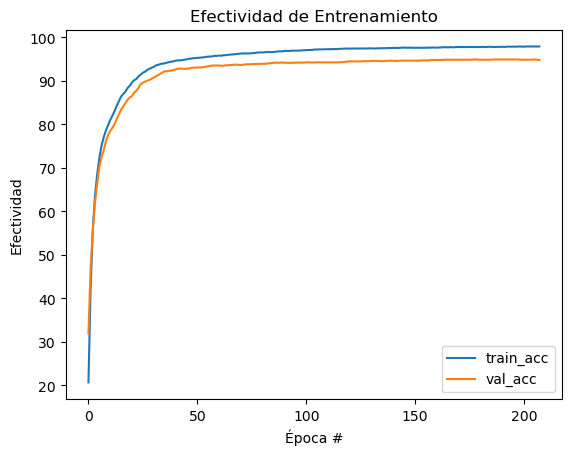

In [12]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["accuracy"])
val_accuracy = np.array(H.history["val_accuracy"])

N = np.arange(0, len(accuracy))
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, 100*accuracy, label="train_acc")
plt.plot(N, 100*val_accuracy, label="val_acc")
plt.title("Efectividad de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Efectividad")
plt.legend(loc="lower right")

In [13]:
report = metrics.classification_report(Y_train,Y_pred2)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       376
           1       0.97      0.97      0.97       389
           2       0.99      0.98      0.99       380
           3       0.99      0.98      0.98       389
           4       0.97      0.99      0.98       387
           5       0.98      0.98      0.98       376
           6       0.97      0.99      0.98       377
           7       0.99      1.00      0.99       387
           8       0.97      0.95      0.96       380
           9       0.96      0.96      0.96       382

    accuracy                           0.98      3823
   macro avg       0.98      0.98      0.98      3823
weighted avg       0.98      0.98      0.98      3823



In [14]:
MM = metrics.confusion_matrix(Y_test,Y_test_pred2)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[176   0   0   0   1   1   0   0   0   0]
 [  0 171   0   0   0   0   3   0   2   6]
 [  0   4 166   4   0   1   2   0   0   0]
 [  0   0   4 171   0   3   0   0   2   3]
 [  0   1   0   0 177   0   0   0   3   0]
 [  0   0   0   0   0 179   1   0   0   2]
 [  0   1   0   0   2   0 178   0   0   0]
 [  0   0   0   0   1   5   0 169   1   3]
 [  0  15   0   2   0   6   1   0 145   5]
 [  0   1   0   1   2   1   0   0   1 174]]


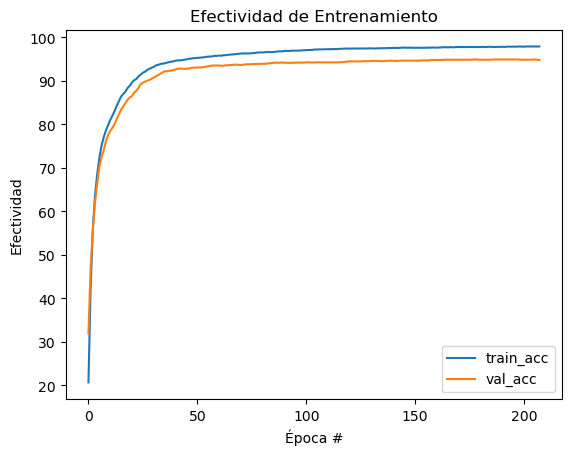

In [15]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["accuracy"])
val_accuracy = np.array(H.history["val_accuracy"])

N = np.arange(0, len(accuracy))
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, 100*accuracy, label="train_acc")
plt.plot(N, 100*val_accuracy, label="val_acc")
plt.title("Efectividad de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Efectividad")
plt.legend(loc="lower right")